In [4]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Set CUDA device to 1 explicitly
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Make only GPU 1 visible
# Alternatively, you can use:
device = torch.device("cuda:0")  # This will now refer to the first visible device (CUDA 1)
print(f"Using device: {device}")

Using device: cuda:0


In [6]:
data = pd.read_csv('/media/ssd/test/standardized-datasets/combined/combined_unsw_cicRed_botRed_netflow_10pct.csv')

In [7]:
# Example if you wanted to keep only certain columns
columns_to_keep = ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO',
                   'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack']
data = data[columns_to_keep]

In [8]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,59.166.0.9,36583,149.171.126.0,5190,6,0.0,2158.0,2464.0,24,24,27,0.0,0,Benign
1,172.31.66.62,52131,169.254.169.254,80,6,7.0,373.0,700.0,5,5,27,0.0,0,Benign
2,59.166.0.3,41889,149.171.126.6,80,6,7.0,1684.0,10168.0,14,18,27,0.0,0,Benign
3,18.219.32.43,49243,172.31.69.28,80,6,7.0,522.0,1147.0,5,5,219,4294957.0,1,DDOS attack-HOIC
4,172.31.69.6,50462,172.31.0.2,53,17,0.0,68.0,196.0,1,1,0,0.0,1,Infilteration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655089,13.58.98.64,51524,172.31.69.25,22,6,92.0,3236.0,3765.0,25,21,27,0.0,1,SSH-Bruteforce
655090,59.166.0.4,59990,149.171.126.0,5190,6,0.0,1036.0,2262.0,12,12,27,0.0,0,Benign
655091,18.218.115.60,50839,172.31.69.28,80,6,7.0,471.0,1147.0,5,5,219,4294941.0,1,Brute Force -XSS
655092,5.188.9.25,50099,172.31.66.110,30488,6,0.0,40.0,0.0,1,0,2,0.0,0,Benign


In [9]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [10]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

In [11]:
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

In [12]:
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

In [13]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,172.21.125.14:36583,149.171.126.0:5190,6,0.0,2158.0,2464.0,24,24,27,0.0,0,Benign
1,172.30.214.66:52131,169.254.169.254:80,6,7.0,373.0,700.0,5,5,27,0.0,0,Benign
2,172.27.3.173:41889,149.171.126.6:80,6,7.0,1684.0,10168.0,14,18,27,0.0,0,Benign
3,172.23.157.51:49243,172.31.69.28:80,6,7.0,522.0,1147.0,5,5,219,4294957.0,1,DDOS attack-HOIC
4,172.16.81.14:50462,172.31.0.2:53,17,0.0,68.0,196.0,1,1,0,0.0,1,Infilteration
...,...,...,...,...,...,...,...,...,...,...,...,...
655089,172.19.189.7:51524,172.31.69.25:22,6,92.0,3236.0,3765.0,25,21,27,0.0,1,SSH-Bruteforce
655090,172.24.201.82:59990,149.171.126.0:5190,6,0.0,1036.0,2262.0,12,12,27,0.0,0,Benign
655091,172.27.46.150:50839,172.31.69.28:80,6,7.0,471.0,1147.0,5,5,219,4294941.0,1,Brute Force -XSS
655092,172.17.171.37:50099,172.31.66.110:30488,6,0.0,40.0,0.0,1,0,2,0.0,0,Benign


In [14]:
data.drop(columns=['Label'],inplace = True)

In [15]:
data.rename(columns={"Attack": "label"},inplace = True)

In [16]:
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [17]:
label = data.label

In [18]:
data.drop(columns=['label'],inplace = True)

In [19]:
scaler = StandardScaler()

In [20]:
data =  pd.concat([data, label], axis=1)

In [21]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
0,172.21.125.14:36583,149.171.126.0:5190,6,0.0,2158.0,2464.0,24,24,27,0.0,2
1,172.30.214.66:52131,169.254.169.254:80,6,7.0,373.0,700.0,5,5,27,0.0,2
2,172.27.3.173:41889,149.171.126.6:80,6,7.0,1684.0,10168.0,14,18,27,0.0,2
3,172.23.157.51:49243,172.31.69.28:80,6,7.0,522.0,1147.0,5,5,219,4294957.0,6
4,172.16.81.14:50462,172.31.0.2:53,17,0.0,68.0,196.0,1,1,0,0.0,19
...,...,...,...,...,...,...,...,...,...,...,...
655089,172.19.189.7:51524,172.31.69.25:22,6,92.0,3236.0,3765.0,25,21,27,0.0,22
655090,172.24.201.82:59990,149.171.126.0:5190,6,0.0,1036.0,2262.0,12,12,27,0.0,2
655091,172.27.46.150:50839,172.31.69.28:80,6,7.0,471.0,1147.0,5,5,219,4294941.0,5
655092,172.17.171.37:50099,172.31.66.110:30488,6,0.0,40.0,0.0,1,0,2,0.0,2


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.3, random_state=123,stratify= label)

In [23]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [24]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [25]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [26]:
X_train

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label,h
209112,172.25.96.190:57038,172.31.67.18:445,0.475151,-0.665634,-0.032126,-0.030287,-0.043967,-0.121009,-1.485086,-0.712034,2,"[-1.4850863121411761, -0.6656338082097226, -0...."
106705,172.22.72.108:21127,149.171.126.2:53,-1.464643,-0.542602,-0.032093,-0.030196,-0.044212,-0.127740,-0.297535,-0.712034,2,"[-0.2975348945775958, -0.542602470757504, -0.1..."
496306,172.27.228.36:55668,172.31.69.28:80,0.475151,0.608191,-0.031284,-0.028286,-0.043478,-0.107548,-0.469003,1.404893,6,"[-0.469002901061805, 0.6081913714808415, -0.10..."
426607,172.25.41.135:57560,172.31.69.25:22,0.475151,3.665247,-0.024890,-0.023126,-0.038831,0.000145,-0.012258,-0.712034,22,"[-0.012257638291948614, 3.66524663166353, 0.00..."
305755,172.20.62.233:51638,172.31.0.2:53,-1.464643,-0.542602,-0.032273,-0.030378,-0.044456,-0.134471,-0.297535,-0.712034,2,"[-0.2975348945775958, -0.542602470757504, -0.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...
267957,172.24.91.194:51163,172.31.69.28:80,0.475151,0.608191,-0.031192,-0.028286,-0.043478,-0.107548,-0.469003,1.404861,6,"[-0.469002901061805, 0.6081913714808415, -0.10..."
565842,172.30.33.6:52874,172.31.0.2:53,-1.464643,-0.542602,-0.032276,-0.030108,-0.044456,-0.134471,-0.297535,-0.712034,2,"[-0.2975348945775958, -0.542602470757504, -0.1..."
317766,172.18.6.142:62358,18.219.211.138:8080,0.475151,-1.037106,-0.031164,-0.029875,-0.043478,-0.107548,-0.469003,-0.712034,3,"[-0.469002901061805, -1.0371057563975392, -0.1..."
464679,172.19.164.175:49802,18.219.211.138:8080,0.475151,-1.037106,-0.031164,-0.029875,-0.043478,-0.107548,-0.469003,-0.712034,3,"[-0.469002901061805, -1.0371057563975392, -0.1..."


In [27]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [28]:
G = G.to_directed()


In [29]:
G = from_networkx(G,edge_attrs=['h','label'] )


In [30]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [31]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)


In [32]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [33]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [34]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [35]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [36]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [37]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 26)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [38]:
from sklearn.utils import class_weight
import numpy as np # Ensure numpy is imported

# Calculate unique classes and labels once
labels_array = G.edata['label'].cpu().numpy()
unique_classes = np.unique(labels_array)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=unique_classes, # Use keyword 'classes='
    y=labels_array          # Use keyword 'y='
)

# Optional: Convert to a dictionary usable by many frameworks
class_weights_dict = dict(zip(unique_classes, class_weights))
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 10.961538461538462, 1: 11.61865308604439, 2: 0.07371403714982357, 3: 1.4086027781020194, 4: 23.516153846153845, 5: 27.17583264193434, 6: 0.46622033794912465, 7: 23.86619131883002, 8: 0.6108515008698571, 9: 1.6397466887890837, 10: 0.6466403440738913, 11: 3.6350196588242754, 12: 1.1647041791332884, 13: 7.140532544378698, 14: 5.29802204404187, 15: 1.5971307963973, 16: 3.8865393090822797, 17: 2.258562605277934, 18: 3.042980570154483, 19: 1.7321857576719097, 20: 1.3856941691244016, 21: 58.40104431991849, 22: 1.0611344314190112, 23: 17.654770154770155, 24: 20.65235993514682, 25: 153.36622073578596}


In [39]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [40]:
G = G.to('cuda:0')
G.device

device(type='cuda', index=0)

In [41]:
G.ndata['h'].device


device(type='cuda', index=0)

In [42]:
G.edata['h'].device


device(type='cuda', index=0)

In [46]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,8000):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


torch.save(model.state_dict(), '/media/ssd/test/GNN/Standardized Models/E-GraphSage/best_model.pt')


KeyboardInterrupt: 

In [41]:
X_test = encoder.transform(X_test)

In [42]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [43]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
1206654,172.29.218.179:52119,209.85.203.156:443,0.638945,-1.115472,-0.018389,-0.007713,-0.025332,0.019293,0.842164,-0.640512,2
2287215,172.24.97.207:39304,172.31.66.70:8081,-1.525936,-0.319908,-0.024185,-0.018148,-0.032421,-0.049512,-0.541244,-0.640512,2
1265399,172.23.148.207:50133,192.168.100.7:38292,0.638945,-0.319908,-0.025993,-0.018058,-0.032421,-0.045465,3.271065,1.565255,20
2110420,172.19.224.116:51150,216.58.198.66:80,0.638945,-1.107265,-0.021445,0.019608,-0.024959,0.051672,0.842164,-0.640512,2
2218560,172.18.164.216:51092,149.171.126.7:21,0.638945,0.350787,-0.026136,-0.017714,-0.032421,-0.037370,-0.666685,-0.640512,2
...,...,...,...,...,...,...,...,...,...,...,...
1249056,172.20.176.138:54889,172.31.64.117:3389,0.638945,-0.319908,-0.019874,-0.013848,-0.029063,-0.017133,-0.650354,-0.640512,2
740595,172.27.148.170:49796,172.31.0.2:53,-1.525936,-0.319908,-0.025891,-0.017957,-0.032421,-0.045465,-0.541244,-0.640512,2
393464,172.23.207.26:57686,172.31.69.25:80,0.638945,0.751012,-0.008462,-0.007197,-0.023094,0.035482,0.842164,1.565143,12
2310753,172.26.42.238:50764,23.15.7.96:80,0.638945,0.751012,-0.025470,-0.017941,-0.031302,-0.041418,-0.901498,-0.640512,2


In [44]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [45]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [46]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [47]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [48]:
G_test = G_test.to('cuda:0')


In [49]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [50]:
print(str(elapsed) + ' seconds')


0.12831923365592957 seconds


In [51]:
test_pred = test_pred.argmax(1)


In [52]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [53]:
actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [54]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

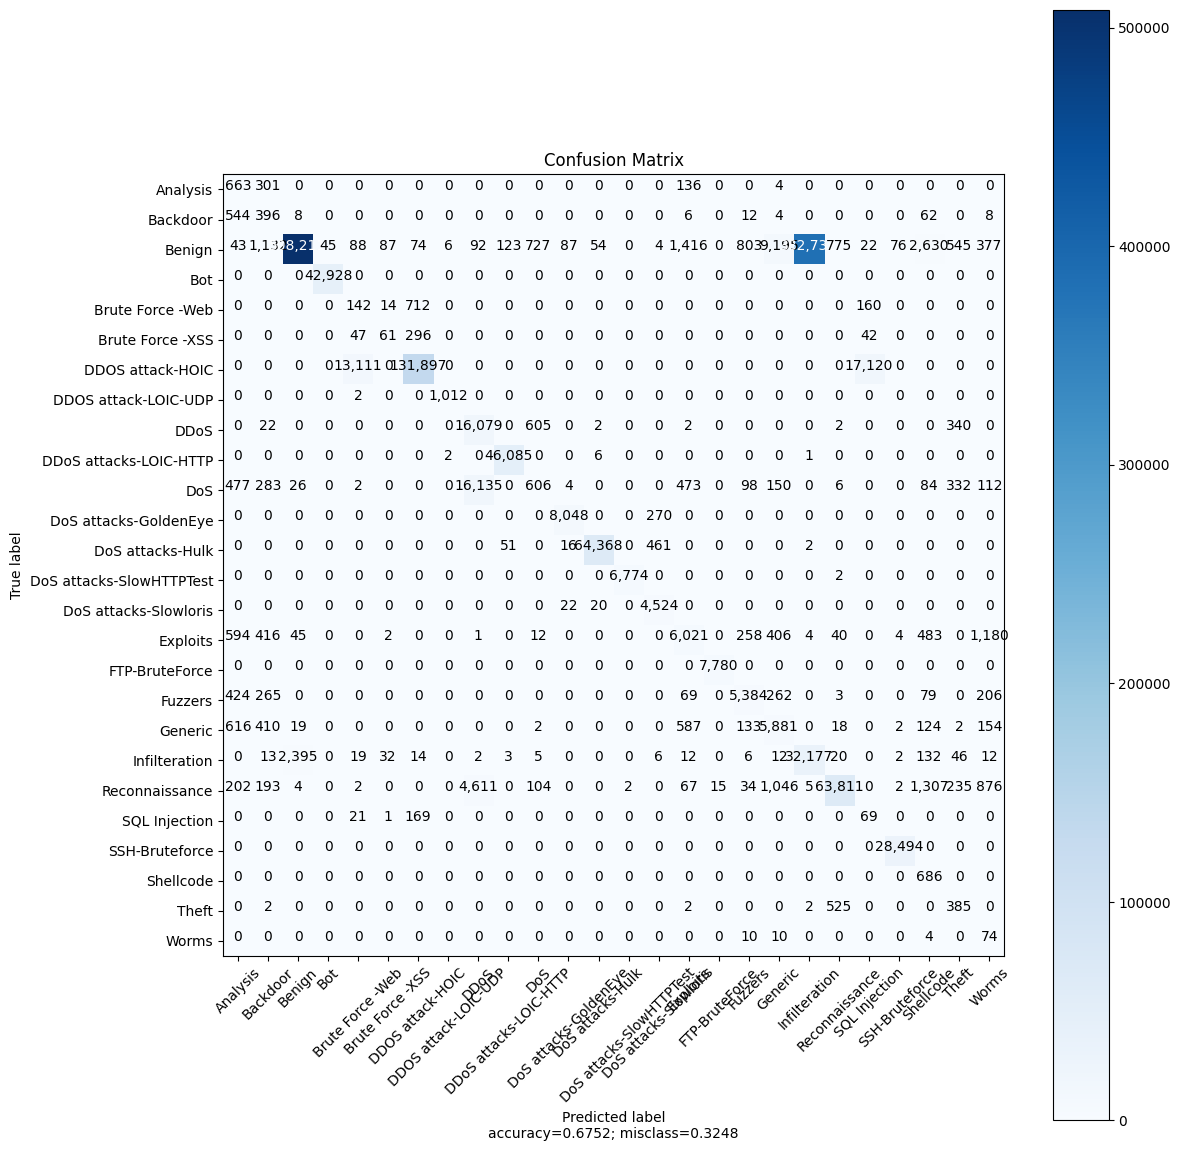

In [55]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")